In [ ]:
%pip install librosa keras tensorflow scikit-learn matplotlib numpy


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\iaman\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Feature extraction (MFCC from GTZAN dataset)

In [7]:
import os
import librosa
import numpy as np
import json
import math

DATASET_PATH = "C:/Internship/Project1/gtzan/Data/genres_original"
JSON_PATH = "data.json"
SAMPLES_PER_TRACK = 22050 * 30  # 30 seconds per track
def extract_features(dataset_path, json_path, num_mfcc=40, n_fft=2048, hop_length=512, num_segments=20):
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": []
    }

    num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    expected_num_mfcc_vectors = math.ceil(num_samples_per_segment / hop_length)

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath != dataset_path:
            genre_label = os.path.basename(dirpath)
            data["mapping"].append(genre_label)
            print(f"Processing {genre_label}")

            for f in filenames:
                if not f.endswith('.wav'):
                    continue
                file_path = os.path.join(dirpath, f)
                try:
                    signal, sr = librosa.load(file_path, sr=22050)
                except Exception as e:
                    print(f"Could not process {file_path}: {e}")
                    continue


                for s in range(num_segments):
                    start = num_samples_per_segment * s
                    finish = start + num_samples_per_segment

                    mfcc_feat = librosa.feature.mfcc(y=signal[start:finish], sr=sr, 
                                                n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc_feat = mfcc_feat.T

                    if len(mfcc_feat) == expected_num_mfcc_vectors:
                        data["mfcc"].append(mfcc_feat.tolist())
                        data["labels"].append(i - 1)


    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
    print(f"Features extracted and saved to {json_path}")
extract_features(DATASET_PATH, JSON_PATH)

Processing blues
Processing classical
Processing country
Processing disco
Processing hiphop
Processing jazz


C:\Users\iaman\AppData\Local\Temp\ipykernel_23156\2626494269.py:31: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(file_path, sr=22050)
C:\Users\iaman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Could not process C:/Internship/Project1/gtzan/Data/genres_original\jazz\jazz.00054.wav: 
Processing metal
Processing pop
Processing reggae
Processing rock
Features extracted and saved to data.json


Load data for training

In [11]:
from sklearn.model_selection import train_test_split
import numpy as np

def load_data(json_path):
    with open(json_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return train_test_split(X, y, test_size=0.2, random_state=42)


Build CNN model

In [46]:
%pip install tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical

def build_model(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (2, 2), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))

    return model


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\iaman\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Train and Evaluate the Model

In [31]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.0003)

X_train, X_test, y_train, y_test = load_data("data.json")

X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

model = build_model(X_train.shape[1:], 10)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), batch_size=32, epochs=50)

# Save the model
model.save("genre_classifier_cnn.h5")


C:\Users\iaman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 60ms/step - accuracy: 0.2575 - loss: 2.2551 - val_accuracy: 0.3644 - val_loss: 2.3299
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 57ms/step - accuracy: 0.4178 - loss: 1.5777 - val_accuracy: 0.4647 - val_loss: 1.6969
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step - accuracy: 0.4840 - loss: 1.4086 - val_accuracy: 0.4880 - val_loss: 1.4927
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step - accuracy: 0.5202 - loss: 1.3129 - val_accuracy: 0.5726 - val_loss: 1.1968
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 57ms/step - accuracy: 0.5517 - loss: 1.2331 - val_accuracy: 0.5553 - val_loss: 1.3021
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 57ms/step - accuracy: 0.5954 - loss: 1.1166 - val_accuracy: 0.6449 - val_loss: 1.0433
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 57ms/step - accuracy: 0.6094 - loss: 1.0884 - val_accuracy: 0.6176 - val_loss: 1.1776
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 57ms/step - accuracy: 0.6118 - loss: 1.0554 - 

Predict Genre from Uploaded Audio

In [ ]:
import librosa
import numpy as np
from tensorflow.keras.models import load_model

def predict_genre(file_path, model, mapping, num_mfcc=40, n_fft=2048, hop_length=512):
    # Load audio file
    signal, sr = librosa.load(file_path, sr=22050)

    # Extract MFCCs
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfcc = mfcc.T  # Transpose to shape (time, features)

    if mfcc.shape[0] < 65:
        pad_width = 65 - mfcc.shape[0]
        mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')
    else:
        mfcc = mfcc[:65, :]

    # Add batch and channel dimensions
    mfcc = mfcc[np.newaxis, ..., np.newaxis]  # shape becomes (1, 65, 40, 1)

    # Predict
    predictions = model.predict(mfcc)
    predicted_index = np.argmax(predictions)
    confidence = predictions[0][predicted_index]

    return mapping[predicted_index], confidence

model_path = "genre_classifier_cnn.h5"   # Path to your trained model
audio_path = "C:/Internship/Project1/gtzan/Data/genres_original/reggae/reggae.00000.wav"         # Replace with actual .wav file path

model = load_model(model_path)

# Define the genre labels (example for GTZAN)
mapping = ['blues', 'classical', 'country', 'disco', 'hiphop',
           'jazz', 'metal', 'pop', 'reggae', 'rock']

genre, confidence = predict_genre(audio_path, model, mapping)
print(f"Predicted genre: {genre} ({confidence:.2f} confidence)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Predicted genre: reggae (0.96 confidence)


Spectrogram

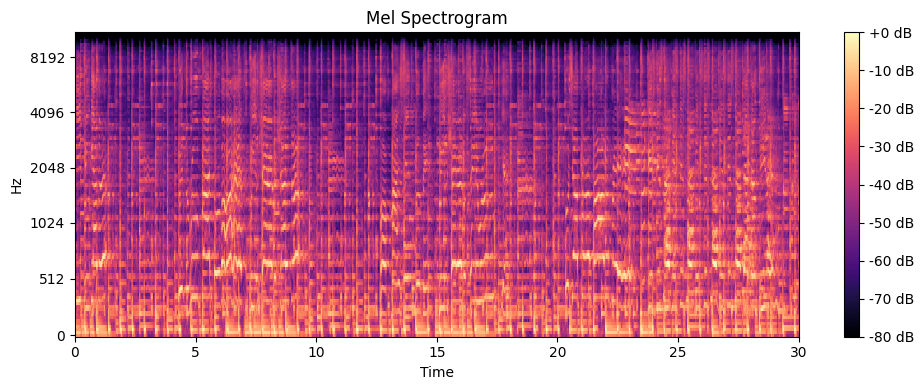

In [39]:
import matplotlib.pyplot as plt
import librosa.display

def display_spectrogram(file_path):
    y, sr = librosa.load(file_path)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_DB = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.tight_layout()
    plt.show()
display_spectrogram(audio_path)


Audio Upload & Demo

In [44]:
from IPython.display import Audio

# Upload and test
uploaded_path = "C:/Internship/Project1/157747__flick3r__fairytale.wav"
Audio(uploaded_path)

genre, conf = predict_genre(uploaded_path, model, [
    'blues', 'classical', 'country', 'disco', 'hiphop',
    'jazz', 'metal', 'pop', 'reggae', 'rock'
])

print(f"Predicted Genre: {genre} ({conf:.2f} confidence)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Genre: jazz (1.00 confidence)
